In [14]:
import math 
import random
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [15]:
# From micrograd 
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # _children keeps a set of values used to create the new Value object
        self._prev = set(_children)
        # _opt keeps information on which operation was used 
        self._op = _op
        self.label = label

    # Define how we wnat to print out our Value objects 
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # allow addition with integers (not only Value objects)
        other = other if isinstance(other, Value) else Value(other)
        
        # return a new value object with the added value. 
        out = Value(self.data + other.data, (self, other), '+')
        # Since data is a Python number, not a Value object, we can use a typical floating point addition.  
        
        def _backward(): # same as out.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
        

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():  # use chain rule
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out

        
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    
    # Used for tanh - activation function 
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): # derivative of tanh is 1-tanh^2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
    
        return out
        
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [46]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f  | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [47]:
import torch 

In [48]:
# Define the input tensors and set requires_grad to True to compute gradients
x1 = torch.Tensor([2.0]).double();                 x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                 x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                 w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();   b.requires_grad = True
# Since thees are leaf nodes, by default, PyTorch assumes they do not need gradients. 
# Therefore, we need to explicitly say all of the nodes require gradients.

# Compute the output of the neural network
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

# Print the output value
print(o.data.item())

# Compute the gradients
o.backward()

# Print the gradients
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [49]:
o # It is a tensor element and it has the backward funciton!

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [50]:
o.item() # o.item() and o.data.item() will produce the same result in PyTorch

0.7071066904050358

In [67]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x))) # check what zip does
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):        
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [115]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.49251160060234306)

In [116]:
n.parameters()

[Value(data=-0.8579970486959063),
 Value(data=-0.904593741635412),
 Value(data=0.4011171548932497),
 Value(data=-0.6569964812744389),
 Value(data=0.7866798654328568),
 Value(data=0.42907509283098433),
 Value(data=-0.5078915080911144),
 Value(data=0.748798665892928),
 Value(data=-0.43895605732366416),
 Value(data=0.6260781209326702),
 Value(data=-0.6159386755374299),
 Value(data=-0.5561522724188039),
 Value(data=-0.6621633127176076),
 Value(data=-0.9736794080733855),
 Value(data=0.21951420567718438),
 Value(data=-0.1341272097558297),
 Value(data=-0.6358528669083052),
 Value(data=-0.8639721919276462),
 Value(data=-0.16477246223440178),
 Value(data=-0.728202779183108),
 Value(data=0.4657972448608978),
 Value(data=0.9382102183643339),
 Value(data=-0.8149597688522547),
 Value(data=-0.9575043601521578),
 Value(data=0.20941594334604385),
 Value(data=0.16212914864052164),
 Value(data=0.44476043548765865),
 Value(data=0.010109622307246768),
 Value(data=-0.7051351789697016),
 Value(data=0.060478

In [117]:
len(n.parameters())

41

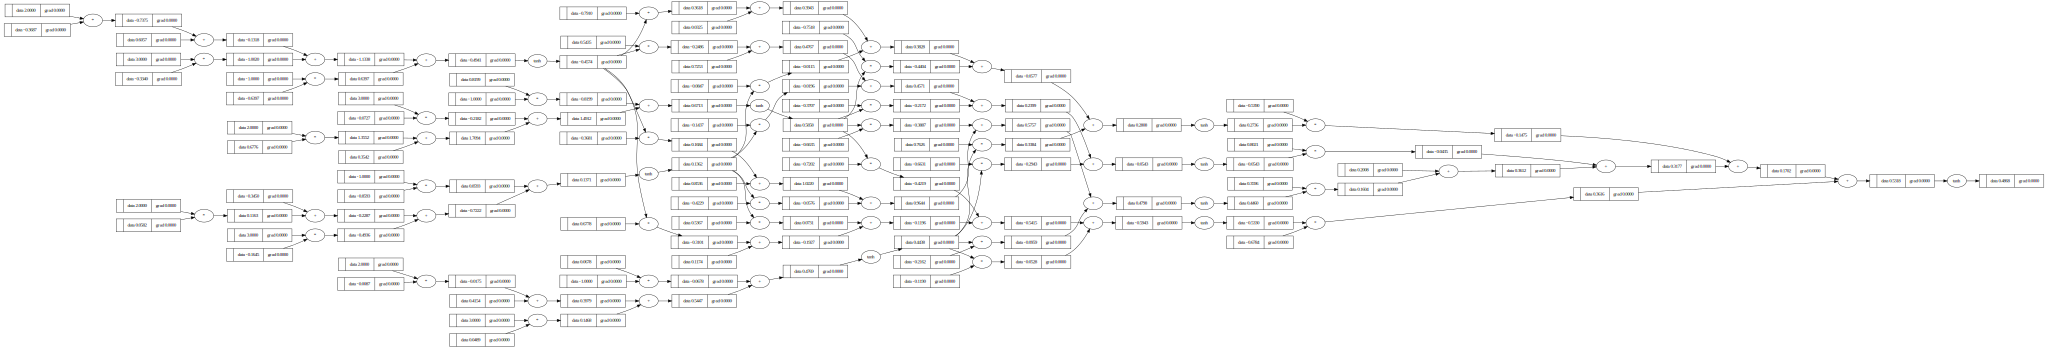

In [72]:
draw_dot(n(x))

In [118]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.49251160060234306),
 Value(data=-0.9412969357592128),
 Value(data=-0.9275614657114447),
 Value(data=-0.7868781497455472)]

In [119]:
[(ygt-yout)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=2.227590877932568),
 Value(data=0.003446049751257988),
 Value(data=0.0052473412498742),
 Value(data=3.1929335220380706)]

In [120]:
loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.429217790971771)

In [76]:
loss.backward()

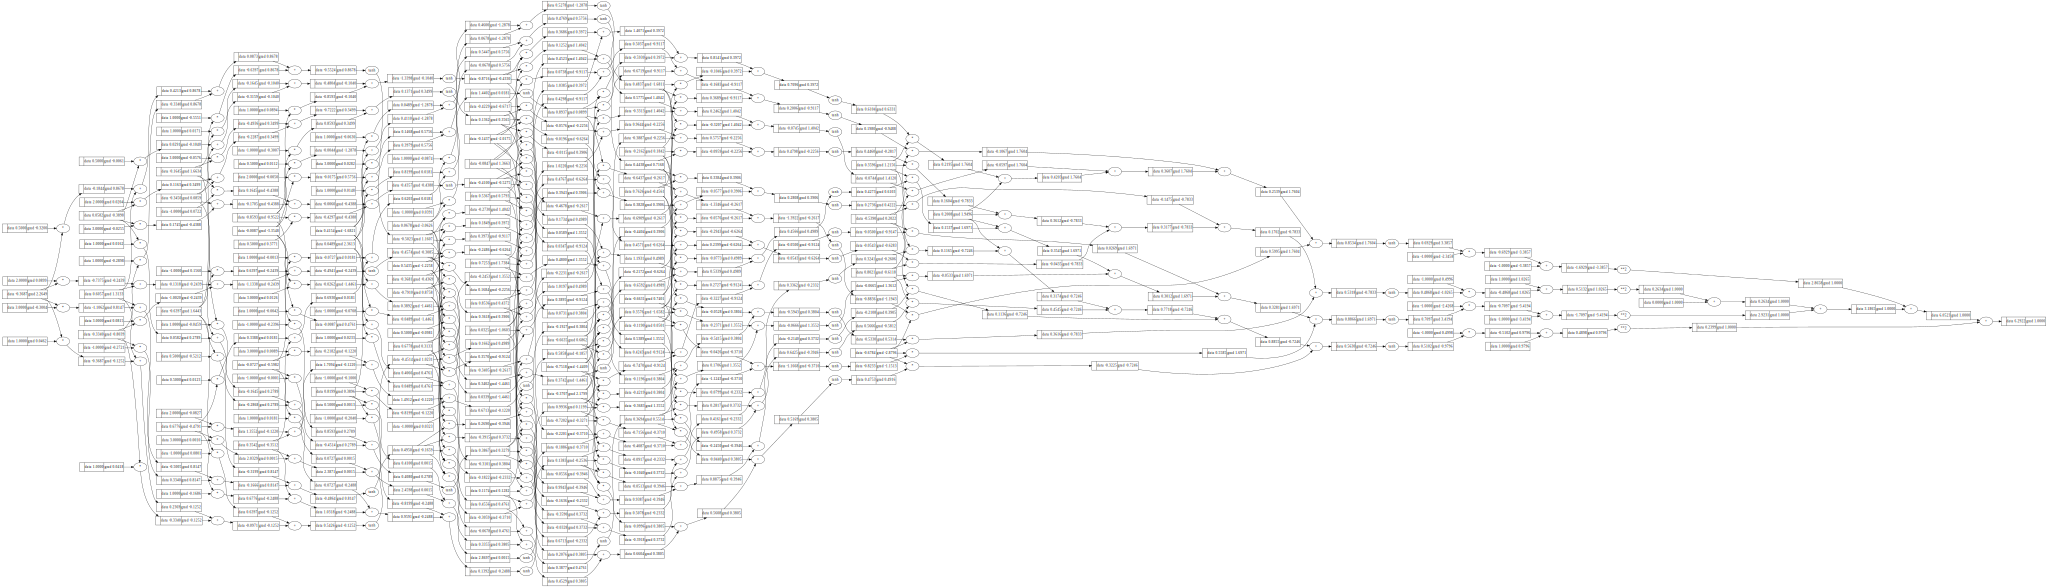

In [79]:
draw_dot(loss)

In [80]:
n.layers[0].neurons[0].w[0].grad

2.264926594396717

In [81]:
n.layers[0].neurons[0].w[0].data

-0.3687390046541663

In [82]:
for p in n.parameters(): # for all 41 parameters
    p.data += -0.01 * p.grad # nudge the data by a small amount. 
    # beware of the sign - negative!!
    # 0.01 is the learning rate. If it's too low, it will learn very slow, if it's too large, it might jump over the local minimum. 
    # We do not know how the loss function graph looks like, so becareful what value you use for the lr.

In [83]:
# check how the weight changes for the first neuron in the first layer
n.layers[0].neurons[0].w[0].data

-0.39138827059813347

In [109]:
ypred = [n(x) for x in xs]
loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
loss # notice how the loss is reduced!

Value(data=0.05930986020825794)

In [110]:
loss.backward()

In [111]:
for p in n.parameters():
    p.data += -0.01 * p.grad 

In [112]:
ypred = [n(x) for x in xs]
loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
loss # notice how the loss is reduced even more! -> we will have to repeat this process until loss is minimized

Value(data=0.028552170641674854)

In [114]:
# Repeat running the forward pass, backward pass, update until loss is very low
ypred

[Value(data=0.8765462696492088),
 Value(data=-0.9580857998228461),
 Value(data=-0.946601290887522),
 Value(data=0.906709460325393)]

In [123]:
# Re-initialize the neural network from scratch

for k in range(20): # epochs = 20

    # forward pass 
    ypred = [n(x) for x in xs]
    loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    loss.backward()

    # update 
    for p in n.parameters():
        p.data += -0.05 * p.grad # lr = 0.05

    print(k, loss.data)
    

0 5.429217790971771
1 0.6837058183498503
2 3.4734657414257866
3 2.275616294324669
4 0.023821210944865383
5 0.007545892498128177
6 0.0067425810376754
7 0.006386116613789709
8 0.006143686926451111
9 0.006124814443043701
10 0.006417287331130511
11 0.007023485339819679
12 0.007735270361283417
13 0.007995995428879504
14 0.007185684534752533
15 0.005351671455208187
16 0.0032580756763895134
17 0.001610860278439317
18 0.0006250419204105398
19 0.00017234231195125085


In [124]:
ypred

[Value(data=0.9868973984712012),
 Value(data=-0.9999823357868572),
 Value(data=-0.9999998790636038),
 Value(data=0.9991852404712322)]

### Notice any error? 
### Forgot to .zero_grad() before .backward()
We need to flush the used .grad after updating the .data

(The only reason we were able to get away with it is becasue the problem is very simple) 

In [181]:
# Reset the neural net 
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.1502694230869919)

In [182]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 
ypred = [n(x) for x in xs]
ypred

[Value(data=0.1502694230869919),
 Value(data=0.5433244417372469),
 Value(data=0.45132380491573),
 Value(data=0.32577453530416295)]

In [195]:
# Fix the error! (.zero_grad())

for k in range(20): # epochs = 20

    # forward pass 
    ypred = [n(x) for x in xs]
    loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters(): # zero grad
        p.grad = 0.0
    loss.backward()

    # update 
    for p in n.parameters():
        p.data += -0.05 * p.grad # lr = 0.05

    print(k, loss.data)

# Run this code until we get a satisfying loss

0 0.008618798844414754
1 0.008534196995614191
2 0.008451121815010528
3 0.00836953328792766
4 0.008289392770692686
5 0.00821066293279918
6 0.008133307701961067
7 0.008057292211890239
8 0.007982582752642794
9 0.00790914672338695
10 0.007836952587458047
11 0.007765969829571417
12 0.007696168915074376
13 0.007627521251124897
14 0.007559999149692345
15 0.007493575792280679
16 0.007428225196282514
17 0.007363922182876504
18 0.007300642346386692
19 0.0072383620250263256


In [196]:
ypred

[Value(data=0.9815687848775505),
 Value(data=-0.9662025557808216),
 Value(data=-0.9464020795674837),
 Value(data=0.9463003908422278)]